# Explainable AI
this script includes the scaffold needed to test out explainable AI for the melanoma classification project. access to the following data is given
- a ML model
- input shape expected by that model
- a single image and a corresponding prediction

## Import utils script setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import numpy; print(numpy.__version__)

2.8.3
2.8.0
1.21.5


## Getting the model

#### Load model into memory

In [3]:
from tensorflow.keras.models import load_model
from efficientnet.tfkeras import EfficientNetB0

# DOWNLOAD THE MODEL FROM GOOGLE DRIVE AND PUT IT IN THE FOLDER SPECIFIED HERE !!!!
model_path = "git-ignored-models/model_15112022164340.h5" # transfer learning model on 200 images 
model = load_model(model_path)

#### Investigate expected shape

In [4]:
from math import sqrt

input_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
expect_flattened_input = len(input_shape) == 2
img_pixel = int(sqrt(input_shape[1]/3) if expect_flattened_input else input_shape[1])

In [5]:
are_flat = "are" if expect_flattened_input else "are not"
print(f"the model expects images with size {img_pixel}*{img_pixel} which {are_flat} flattened out")

the model expects images with size 240*240 which are not flattened out


## Load images

#### Config on where to find the data

In [6]:
base_path = "data" 
downsampled_data = False
partition = "test"
num_images = 1

In [7]:
img_folder = base_path + "/" + partition + ("_downsampled" if downsampled_data else "")
groundtruth_file = base_path + "/ISIC_2020_2019_" + partition + ("_downsampled" if downsampled_data else "") + ".csv" 

#### Getting image(s)

In [8]:
from utilities import get_img_paths, load_data, split_predictors_target, unflatten_images_df

img_paths = get_img_paths(img_folder, num_images) 
df = load_data(img_paths, groundtruth_file, img_pixel=img_pixel)
X, y = split_predictors_target(df) 

if not expect_flattened_input:
    X = unflatten_images_df(X, img_pixel=img_pixel)

## Predict and display images

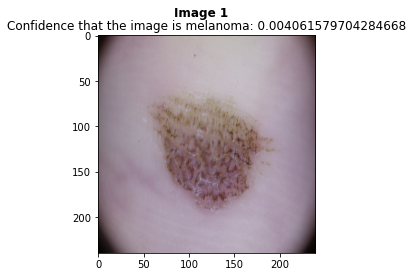

In [9]:
import matplotlib.pyplot as plt
depth = 3

# predict images
y_pred = model.predict(X)

if expect_flattened_input:
    print("this will crash c:")

for i in range(X.shape[0]):
    # output prediction
    title = f"Image {i+1}"
    prediction = f"Confidence that the image is melanoma: {y_pred[i][0]}"
    img_to_display = X[i]

    # display image
    plt.figure()
    plt.imshow(img_to_display)
    plt.title(prediction)
    plt.suptitle(title, fontweight ="bold")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

from utilities import random_state

np.random.seed(random_state())

In [11]:
explainer = lime_image.LimeImageExplainer()

In [12]:
# helper functions

def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    plt.figure()
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    
    plt.title(f"Highlight super-pixel, \nshow positive: {show_positive} hide background: {hide_background}")
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
    
#Heatmap
#show how important each super-pixel is to get more granular explaianbility.
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    plt.figure()
    plt.title("explanation heatmap")
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

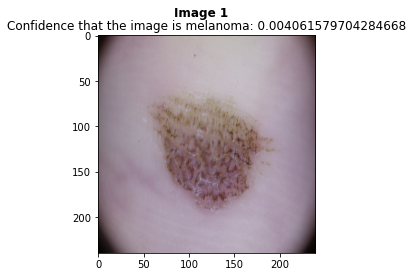

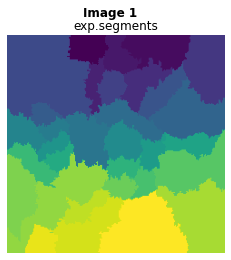

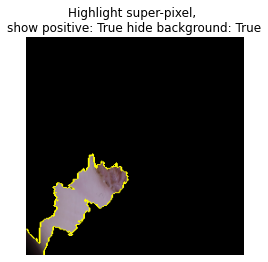

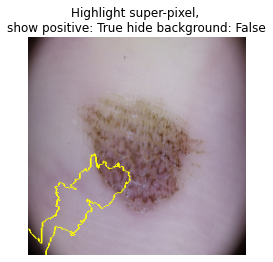

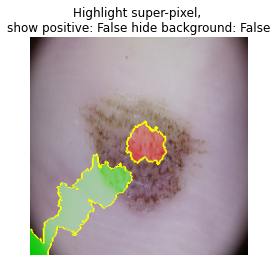

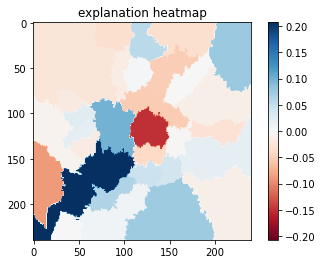

In [13]:
import matplotlib.pyplot as plt
depth = 3

# predict images
y_pred = model.predict(X)

if expect_flattened_input:
    print("this will crash c:")

for i in range(X.shape[0]):
    # output prediction
    title = f"Image {i+1}"
    prediction = f"Confidence that the image is melanoma: {y_pred[i][0]}"
    img_to_display = X[i]


    exp = explainer.explain_instance(img_to_display, 
                             model.predict, 
                             top_labels=5, # might not need
                             hide_color=0, 
                             num_samples=1000)

    # display image
    plt.figure()
    plt.title(prediction)
    plt.suptitle(title, fontweight ="bold")
    plt.imshow(img_to_display)
    plt.show()

    # display some weird lime stuff
    plt.figure()
    plt.title("exp.segments")
    plt.suptitle(title, fontweight ="bold")
    plt.imshow(exp.segments)
    plt.axis('off')
    plt.show()

    generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

    generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)
    #highlight the contour of the superpixel and include the background

    generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)
    #highlight the positive super-pixels and negative superpixels

    explanation_heatmap(exp, exp.top_labels[0])